In [60]:
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tweepy

# Sentiment Analysis
 - Unsupervised
 - Supervised

In [37]:
hotstar_data = pd.read_csv('hotstar.allreviews_Sentiments.csv')
hotstar_data.head(5)

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,8/10/2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,8/11/2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,8/12/2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,8/11/2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,8/5/2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [8]:
hotstar_data.shape

(5053, 13)

In [38]:
hotstar_data['Sentiment_Manual'].value_counts()

Neutral     1738
Positive    1733
Negative    1582
Name: Sentiment_Manual, dtype: int64

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

**Sentiment Polarity** - given a sentence , looks up with a list of positive and negative words.<br>
    - Case 1:
         - +ve polarity > 1
         - -ve polarity < 1
         - Neutral      = 0
         
    - Case 2:
         - very positive   > 10
         - positive        5 - 10 , similarly for negative
         
Vader also checks for the intensity of the word, emoticons etc.,  **vader_lexicon.txt** <br>

While using Vader, do not clean , do not remove stop words

In [12]:
senti = SentimentIntensityAnalyzer()

Compound is the overall sentiment for the sentence , ranges between -1 to +1

In [35]:
senti.polarity_scores('i studied at xyz')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [39]:
hotstar_data['sentiment_vader'] = hotstar_data['Reviews'].apply( lambda x:
                                                                          senti.polarity_scores(x)['compound'] )

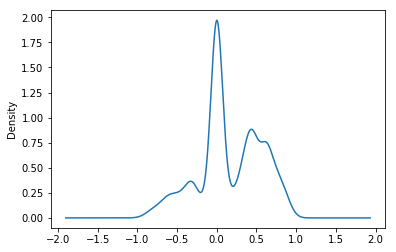

In [40]:
hotstar_data['sentiment_vader'].plot.density()

Most of the predictions are around 0

In [41]:
def assign_sentiment(x):
    if x > 0.25:
        return('Positive')
    elif x < -0.25:
        return('Negative')
    else:
        return('Neutral')
hotstar_data['sentiment_vader_cat'] = hotstar_data['sentiment_vader'].apply(assign_sentiment)
hotstar_data['sentiment_vader_cat'].value_counts()

Neutral     2149
Positive    2137
Negative     767
Name: sentiment_vader_cat, dtype: int64

******

# Supervised Models <br>
    - Random Forest - input should be categorical or numeric

In [47]:
stemmer = nltk.stem.PorterStemmer() 

In [45]:
custom_stop_words = []
common_stop_words = nltk.corpus.stopwords.words('english')
all_stop_words = np.hstack([custom_stop_words,common_stop_words])
len(all_stop_words)

179

In [49]:
all_reviews = hotstar_data['Reviews']
all_reviews = all_reviews.str.lower()
all_reviews = all_reviews.str.replace('[^a-z#@ ]','')
all_reviews = all_reviews.str.split(' ')
words_rows = all_reviews.tolist()
words_all = [] # huge list - 59k [] 
docs_clean = [] # stemmed and cleaned sentences joined with space.
words_rows_clean = [] # list of lists [ [],[],[] ... ] 

for row in words_rows:
    row_words = [stemmer.stem(word) for word in row if word not in all_stop_words]    # stemmed
    words_rows_clean.append(row_words) # clean words 
    docs_clean.append(' '.join(row_words))    
    words_all.extend(row_words)


model = CountVectorizer()
sparse_matrix = model.fit_transform(docs_clean)
dtm = pd.DataFrame(sparse_matrix.toarray(),
                   columns = model.get_feature_names())
dtm.shape

(5053, 6152)

**Train Test Split**

In [51]:
X_train,X_test,y_train,y_test = train_test_split(dtm,hotstar_data['Sentiment_Manual'],test_size = 0.2, random_state=0)

In [54]:
y_test.value_counts() / y_test.shape[0] * 100

Neutral     34.520277
Positive    34.520277
Negative    30.959446
Name: Sentiment_Manual, dtype: float64

**Train the model**

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

C:\Users\Goutham\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
preds = rf.predict(X_test)

**Evaluate model**

In [58]:
(y_test == preds).sum() / y_test.shape[0] * 100

74.1839762611276

****

**Predict for new tweets**

In [61]:
api_key = 'QSV92u3PlXAUyzCBUfVwwLccp'
api_secret = 'vxQT5rKUmpycC52eFwitpIh2Ij2hjuw8ZxhnlsbCYhEVv7zqIh'
access_token = '1059829816306921472-ADVpqol7U3AkaJKHVt5bH2VqMnBAQK'
access_token_secret = 'fRfkm7u2uzXvSjPZsuseXGj7nJYgjl5eOROnmWZqOOJVE'
api = tweepy.OAuthHandler(api_key,api_secret)
api.set_access_token(access_token,access_token_secret)
api_auth = tweepy.API(api)

In [62]:
hotstar_tweets = api_auth.search('#hotstar',count=500)
hotstar_df = pd.DataFrame(columns = ['text','created_at','name'])
for tweet in hotstar_tweets:
    curr_row = {'text':tweet.text,
                'created_at':tweet.created_at,
                'name':tweet.user.name}
    hotstar_df = hotstar_df.append(curr_row,ignore_index=True)

In [63]:
hotstar_df.shape

(100, 3)

In [64]:
hotstar_df.to_csv('hotstar_tweets.csv',index=False)

**Sentiment for new tweets** - use the vocabulary from the previously trained model. Any new word will not appear in the list of features

In [68]:
docs = hotstar_df['text']
docs = docs.str.lower()
docs = docs.str.replace('[^a-z#@ ]','')
docs = docs.str.split(' ')
words_rows = docs.tolist()
docs_clean_new = [] # stemmed and cleaned sentences joined with space.

for row in words_rows:
    row_words = [stemmer.stem(word) for word in row if word not in all_stop_words]    # stemmed
    docs_clean_new.append(' '.join(row_words))    

model_new = CountVectorizer(vocabulary=model.vocabulary_)

dtm_new = pd.DataFrame(model_new.fit_transform(docs_clean_new).toarray(),
                      columns = model.get_feature_names())

In [69]:
dtm_new.shape

(100, 6152)

**Term Frequence-Inverse Document Frequency**

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

model_tfidf = TfidfVectorizer()

dtm_tfidf = pd.DataFrame(model_tfidf.fit_transform(docs_clean).toarray(),
                      columns = model.get_feature_names())

In [73]:
dtm_tfidf.sum().sort_values(ascending=False).head()
#dtm.sum().sort_values(ascending=False).head()

app             230.159049
hotstartweet    183.286564
hotstar         173.169018
good            168.675049
watch           130.602828
dtype: float64